In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# visulization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import os
import gc # garbage collection
import glob # extract path via pattern matching
from tqdm.notebook import tqdm # progressbar
import random
import math
import cv2 # read image
# store to disk
import pickle
import h5py # like numpy array
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

from keras.models import Sequential, Model
from keras.models import load_model
from keras.layers import Input, Dense, Conv2D, MaxPool2D, AveragePooling2D
from keras.layers import Flatten, Dropout, BatchNormalization, Activation
from keras.layers import Add
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from keras import regularizers
import keras

from keras.callbacks import ModelCheckpoint, EarlyStopping
# from keras.applications.vgg16 import VGG16


## Load and Explore Data

In [4]:
ROOT_DIR = '../driver-dataset/'
TRAIN_DIR = ROOT_DIR + 'imgs/train/'
TEST_DIR = ROOT_DIR + 'imgs/test/'
driver_imgs_list = pd.read_csv(ROOT_DIR + "driver_imgs_list.csv")

In [5]:
random_list = np.random.permutation(len(driver_imgs_list))[:50]
df_copy = driver_imgs_list.iloc[random_list]
image_paths = [TRAIN_DIR+row.classname+'/'+row.img 
                   for (index, row) in df_copy.iterrows()]


## Prepare Training Data

In [6]:
img_path_list = []
label_list = []
for index, row in driver_imgs_list.iterrows():
    img_path_list.append('{0}{1}/{2}'.format(TRAIN_DIR, row.classname, row.img))
    label_list.append(int(row.classname[1]))
# One hot vector representation of labels
y_labels_one_hot = to_categorical(label_list, dtype=np.int8)
x_img_path = np.array(img_path_list)

In [7]:
np.save('x_img_path.npy', x_img_path)
np.save('y_labels_one_hot.npy', y_labels_one_hot)

In [8]:
from sklearn.utils import shuffle

x_img_path_shuffled, y_labels_one_hot_shuffled = shuffle(x_img_path, y_labels_one_hot)

# saving the shuffled file.
# you can load them later using np.load().
np.save('y_labels_one_hot_shuffled.npy', y_labels_one_hot_shuffled)
np.save('x_img_path_shuffled.npy', x_img_path_shuffled)

In [9]:
from sklearn.model_selection import train_test_split
# Used this line as our filename array is not a numpy array.
x_img_path_shuffled_numpy = np.array(x_img_path_shuffled)

X_train_filenames, X_val_filenames, y_train, y_val = train_test_split(
    x_img_path_shuffled_numpy, y_labels_one_hot_shuffled, test_size=0.2, random_state=1)

print(X_train_filenames.shape) # (3800,)
print(y_train.shape)           # (3800, 12)

print(X_val_filenames.shape)   # (950,)
print(y_val.shape)             # (950, 12)

# You can save these files as well. As you will be using them later for training and validation of your model.
np.save('X_train_filenames.npy', X_train_filenames)
np.save('y_train.npy', y_train)

np.save('X_val_filenames.npy', X_val_filenames)
np.save('y_val.npy', y_val)

(17939,)
(17939, 10)
(4485,)
(4485, 10)


In [12]:
IMG_HEIGHT = 240
IMG_WIDTH = 320
CHANNEL = 1
class Img_Generator(tf.keras.utils.Sequence):
    def __init__(self, image_filenames, labels, batch_size) :
        self.image_filenames = image_filenames
        self.labels = labels
        self.batch_size = batch_size
    def __len__(self) :
        return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(np.int)
    def __getitem__(self, idx) :
        batch_x = self.image_filenames[idx * self.batch_size : (idx+1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]
        img_list = []
        for file_name in batch_x:
            original_img = cv2.imread(file_name, 0)
            im = cv2.resize(original_img, (320, 240))
            #color = [0, 0, 0]
            #new_im = cv2.copyMakeBorder(im, 40, 40, 0, 0, cv2.BORDER_CONSTANT, value=color)
            #im = cv2.resize(new_im, (224, 224))
            img_list.append(im)
        img_batch = np.array(img_list)
        img_batch = np.expand_dims(img_batch, axis=-1)
        return img_batch, np.array(batch_y)

In [13]:
train_gen = Img_Generator(X_train_filenames, y_train, 32)
val_gen = Img_Generator(X_val_filenames, y_val, 32)

## Training

In [15]:
MODELS_DIR = "resnet_models"
if not os.path.exists(MODELS_DIR):
    os.makedirs(MODELS_DIR)

In [19]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

filepath = MODELS_DIR+'/epoch{epoch:02d}-loss{loss:.2f}-val_loss{val_loss:.2f}.hdf5'
# checkpoint
model_checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, 
                                   save_best_only=True, save_weights_only=False, mode='min', period=1)

# early stopping: patience = epocs
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1,
                               mode='min', baseline=None, restore_best_weights=True)

In [21]:
# No need for adaptive learning alogrithms like: RmsProp, Adam
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
# This function keeps the learning rate at 0.01 for the first five epochs
# and decreases it exponentially after that.
def learning_rate_scheduler(epoch):
    if epoch < 5:
        return 0.01
    else:
        return 0.01 * math.exp(0.1 * (5 - epoch))

lr_scheduler = LearningRateScheduler(learning_rate_scheduler, verbose=1)
# OR
# lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, 
#                                             verbose=1, mode='min', min_delta=0.0001, min_lr=0.0001)

In [22]:
def plot_model_loss(history):
    '''
    function to plot learning trace
    '''
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()

In [29]:
def plot_model_accuracy(history):
    '''
    function to plot learning trace
    '''
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()

In [24]:
from tensorflow.keras.applications import MobileNetV2, ResNet50, VGG19, MobileNet
model = ResNet50(include_top=True, weights=None, input_shape=(IMG_HEIGHT, IMG_WIDTH, 1), pooling=None, classes=10)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 320, 1) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 246, 326, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 120, 160, 64) 3200        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 120, 160, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [26]:
EPOCHS = 5
history1 = model.fit_generator(train_gen,
              steps_per_epoch=None,
              epochs=EPOCHS,
              verbose=1,
              callbacks=[model_checkpoint, early_stopping],
              validation_data=val_gen,
              validation_steps=None,
              validation_freq=1,
              class_weight=None,
              max_queue_size=10,
              workers=1, 
              use_multiprocessing=False, 
              shuffle=True, 
              initial_epoch=0)

Epoch 1/5
561/561 [==============================] - 5585s 10s/step - loss: 0.5067 - accuracy: 0.8311 - val_loss: 1.1990 - val_accuracy: 0.6861

Epoch 00001: val_loss improved from inf to 1.19897, saving model to resnet_models/epoch01-loss0.51-val_loss1.20.hdf5


/opt/anaconda3/lib/python3.8/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/5
561/561 [==============================] - 7171s 13s/step - loss: 0.1417 - accuracy: 0.9555 - val_loss: 13.4790 - val_accuracy: 0.1476

Epoch 00002: val_loss did not improve from 1.19897
Epoch 3/5
561/561 [==============================] - 6705s 12s/step - loss: 0.0780 - accuracy: 0.9774 - val_loss: 1.1140 - val_accuracy: 0.7561

Epoch 00003: val_loss improved from 1.19897 to 1.11399, saving model to resnet_models/epoch03-loss0.08-val_loss1.11.hdf5
Epoch 4/5
561/561 [==============================] - 6622s 12s/step - loss: 0.0688 - accuracy: 0.9790 - val_loss: 5.9949 - val_accuracy: 0.4511

Epoch 00004: val_loss did not improve from 1.11399
Epoch 5/5
561/561 [==============================] - 5743s 10s/step - loss: 0.0621 - accuracy: 0.9807 - val_loss: 1.4461 - val_accuracy: 0.7813

Epoch 00005: val_loss did not improve from 1.11399


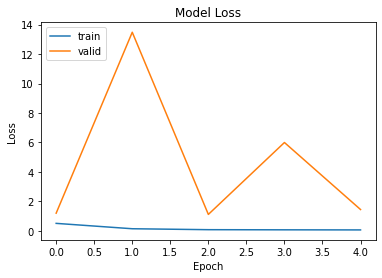

In [27]:
plot_model_loss(history1.history)

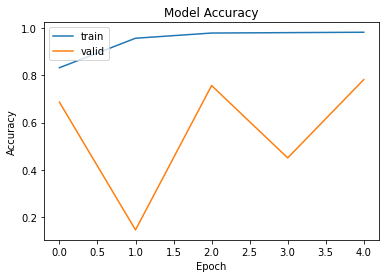

In [30]:
plot_model_accuracy(history1.history)